In [52]:
# Initialization
a = 10
a

10

# Pre Processing

## Library

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error as rmse, mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsRegressor as KNN
from xgboost import XGBRegressor as XGBS
from sklearn.model_selection import GridSearchCV

## Statistic Descriptive

In [54]:
# Load dataset
df = pd.read_csv("winequalityN.csv")

numerical_cols = df.select_dtypes(include='number')

StatisticDescriptive = numerical_cols.describe().T

StatisticDescriptive = StatisticDescriptive.round(2)

print(StatisticDescriptive)

StatisticDescriptive.to_csv("StatisticDescriptiveN.csv")

                       count    mean    std   min    25%     50%     75%  \
fixed acidity         6487.0    7.22   1.30  3.80   6.40    7.00    7.70   
volatile acidity      6489.0    0.34   0.16  0.08   0.23    0.29    0.40   
citric acid           6494.0    0.32   0.15  0.00   0.25    0.31    0.39   
residual sugar        6495.0    5.44   4.76  0.60   1.80    3.00    8.10   
chlorides             6495.0    0.06   0.04  0.01   0.04    0.05    0.06   
free sulfur dioxide   6497.0   30.53  17.75  1.00  17.00   29.00   41.00   
total sulfur dioxide  6497.0  115.74  56.52  6.00  77.00  118.00  156.00   
density               6497.0    0.99   0.00  0.99   0.99    0.99    1.00   
pH                    6488.0    3.22   0.16  2.72   3.11    3.21    3.32   
sulphates             6493.0    0.53   0.15  0.22   0.43    0.51    0.60   
alcohol               6497.0   10.49   1.19  8.00   9.50   10.30   11.30   
quality               6497.0    5.82   0.87  3.00   5.00    6.00    6.00   

           

## Missing Values & Skewed Features

In [55]:
#Load Dataset Raw
#Load CSV Raw Dataset from Kaggle
df = pd.read_csv("winequalityN.csv")

print("Raw Data:", df.shape)

#Check and Handle Missing Value
print("\nMissing values before handling:")
print(df.isnull().sum())

numerical_cols = df.select_dtypes(include='number').columns

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

print("\nMissing values after handling:")
print(df.isnull().sum())

df['type'] = df['type'].map({'white': 0, 'red': 1})

skewed_features = [
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'sulphates'
]

for col in skewed_features:
    df[col] = np.log1p(df[col])

target = 'quality'
categorical_cols = ['type']

numerical_features = df.columns.drop([target] + categorical_cols)

X = df.drop(target, axis=1)
y = df[target]

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

df_processed = X.copy()
df_processed[target] = y.values

# After implementing scaler and erasing missing values, save data to new csv
print("\nData Pre Processed :", df_processed.shape)

output_path = "winequality_preprocessed.csv"
df_processed.to_csv(output_path, index=False)

print(f"\nPreprocessed data saved to: {output_path}")

Raw Data: (6497, 13)

Missing values before handling:
type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Missing values after handling:
type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Data Pre Processed : (6497, 13)

Preprocessed data saved to: winequality_preprocessed.csv


## Training Initialization

In [56]:
def evaluation(model_name,y_pred,y_actual):
    RMSE = rmse(y_actual, y_pred)
    MSE = mse(y_actual, y_pred)
    MAE = mae(y_actual, y_pred)

    print(
    f"Model: {model_name:<20} | "
    f"RMSE: {RMSE:>8.2f} | "
    f"MSE: {MSE:>8.2f} | "
    f"MAE: {MAE:>8.2f}"
    )

    return RMSE,MSE,MAE

def trains(model_name,model,x_train,y_train):
    models = model.fit(x_train,y_train)
    y_pred = models.predict(x_test)
    a,b,c = evaluation(model_name,y_test,y_pred)
    return models,a,b,c

In [57]:
#Check Processed Columns
df_processed.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

## Handle Outliers

In [58]:
def detect_outlier_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    return lowerBound, upperBound

def handle_outlier_capping(data_series):
    lowerBound, upperBound = detect_outlier_iqr(data_series)
    cleanedData = data_series.copy()
    cleanedData[cleanedData < lowerBound] = lowerBound
    cleanedData[cleanedData > upperBound] = upperBound
    return cleanedData

df_Cleaned = df_processed.copy()

print("DataFrame Actual:")
print(df_processed)
print("-" * 50)

featureColumns = df_processed.drop(
    columns=['type', 'quality'], errors='ignore'
).columns

for column in featureColumns:
    print(f"Processing Column: {column}")

    lowerBound, upperBound = detect_outlier_iqr(df_processed[column])
    print(f"   - lowerBound: {lowerBound:.2f}, upperBound: {upperBound:.2f}")

    df_Cleaned[column] = handle_outlier_capping(df_processed[column])

df_Cleaned = df_Cleaned.drop(columns=['type'], errors='ignore')

df_Cleaned['quality'] = df_processed['quality']

print("-" * 50)
print("DataFrame After Handle Outlier:")
print(df_Cleaned)

df_Cleaned.to_csv("winequality_processed.csv", index=False)
print("File CSV saved to: winequality_processed.csv")

DataFrame Actual:
      type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        0      -0.166898         -0.423168     0.284273        2.135486   
1        0      -0.707155         -0.240846     0.146551       -0.975508   
2        0       0.682078         -0.362394     0.559716        0.653961   
3        0      -0.012539         -0.666264     0.008829        0.924371   
4        0      -0.012539         -0.666264     0.008829        0.924371   
...    ...            ...               ...          ...             ...   
6492     1      -0.784334          1.582372    -1.643834       -0.765692   
6493     1      -1.015873          1.278503    -1.506112       -0.671066   
6494     1      -0.707155          1.035407    -1.299529       -0.625948   
6495     1      -1.015873          1.855855    -1.368390       -0.765692   
6496     1      -0.938694         -0.180072     1.041743       -0.138972   

      chlorides  free sulfur dioxide  total sulfur dioxide   density 

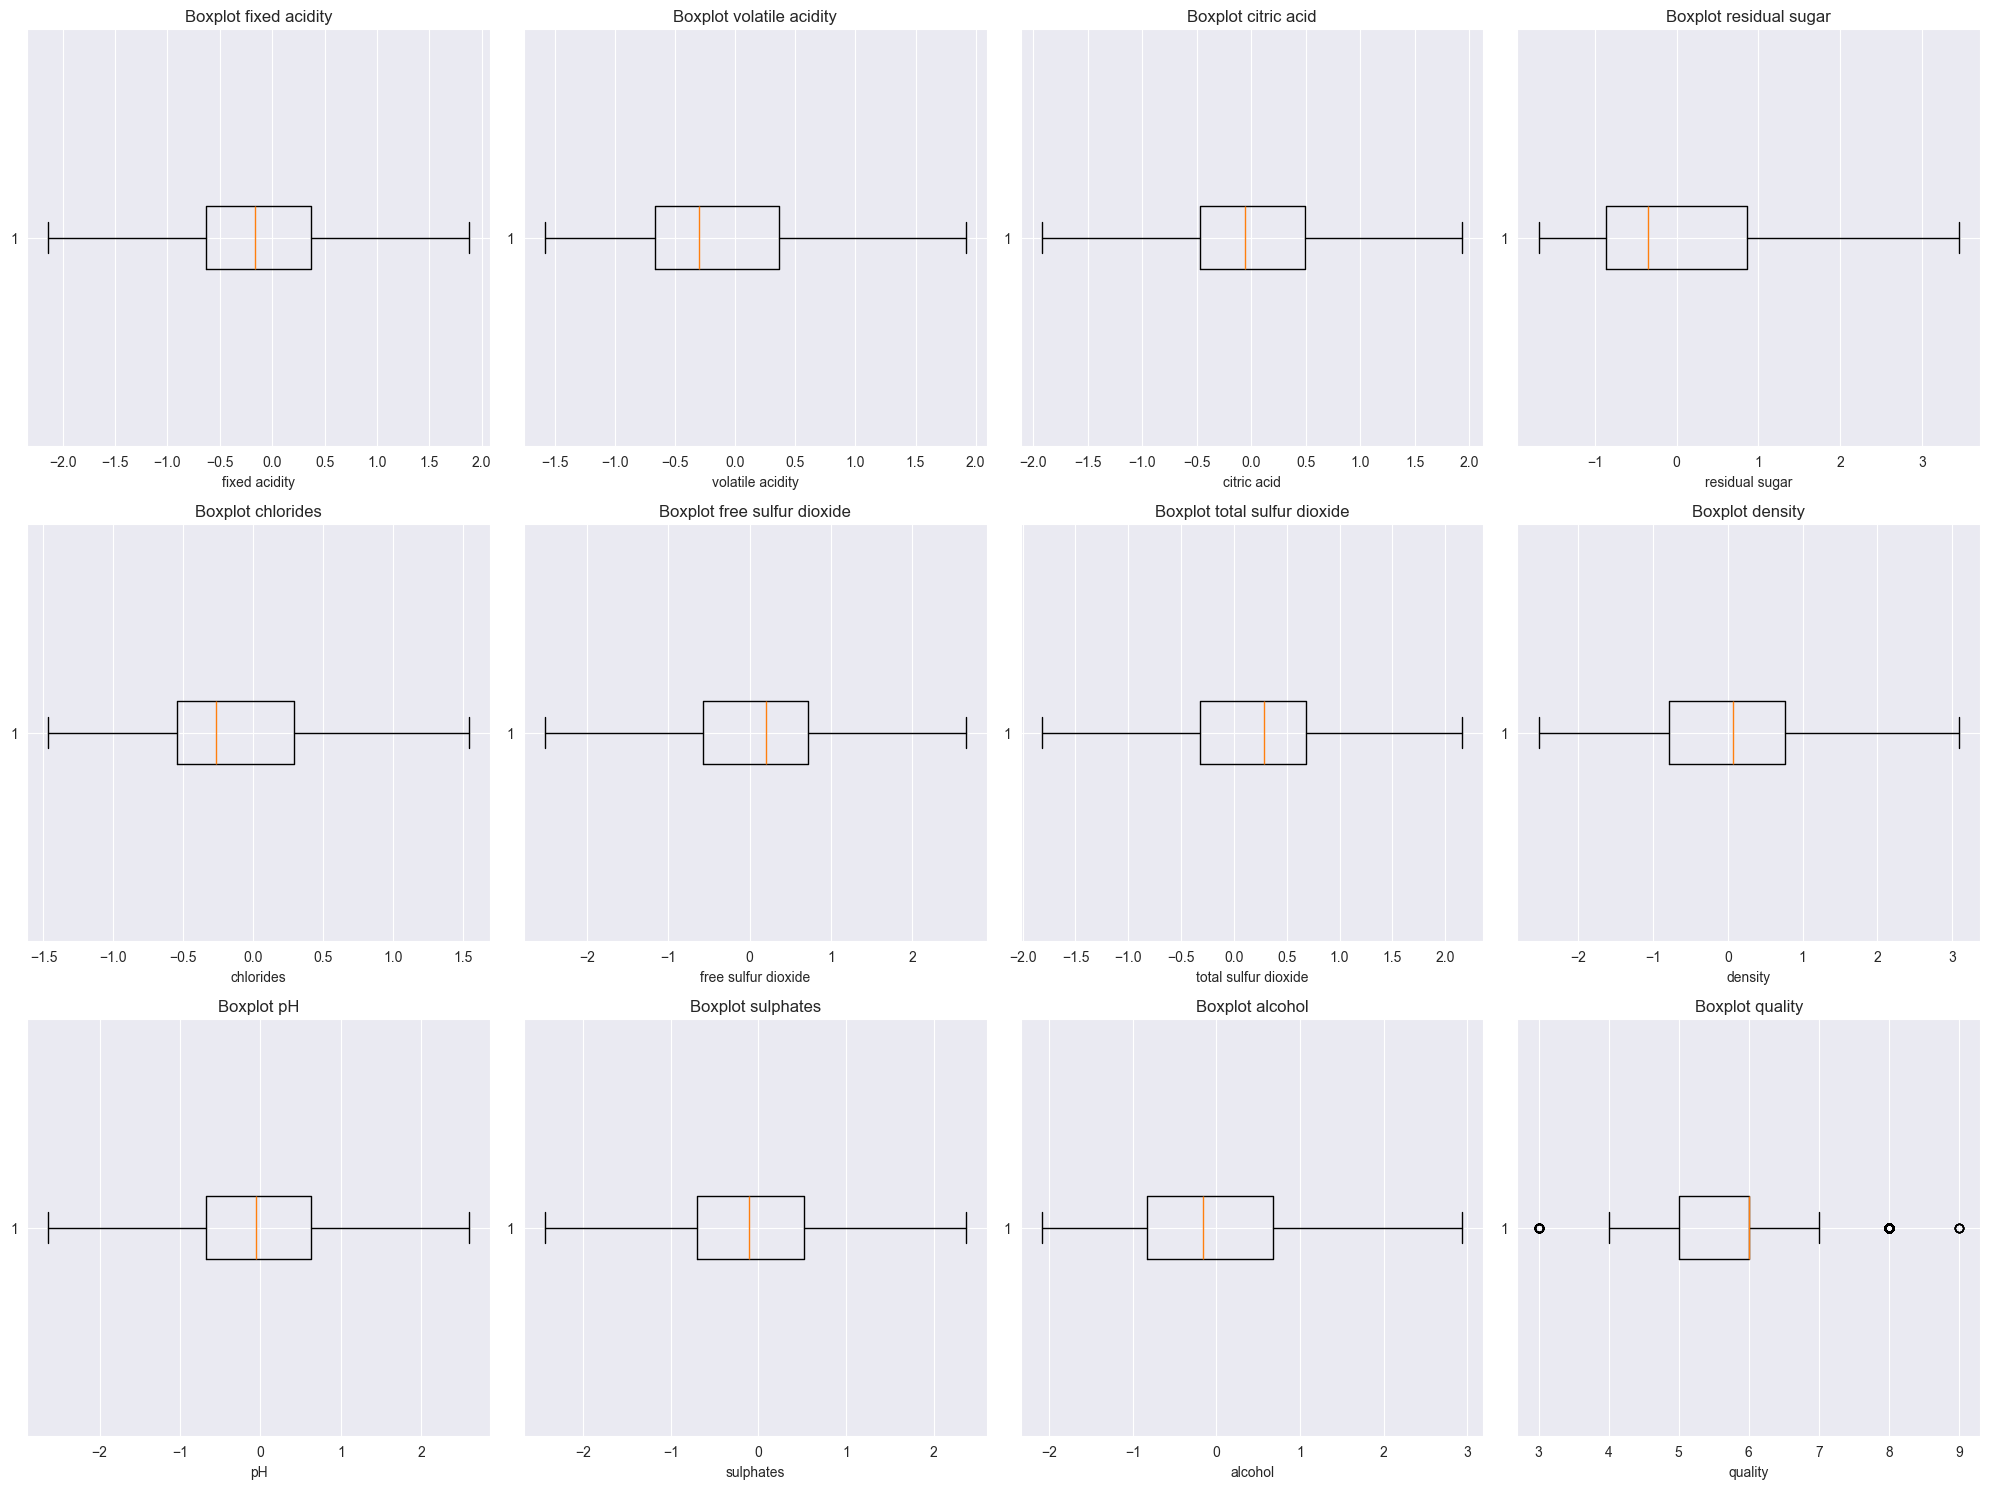

In [59]:
numerical_cols = df_Cleaned.select_dtypes(include='number').columns

n_features = len(numerical_cols)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df_Cleaned[col], vert=False)
    axes[i].set_title(f"Boxplot {col}")
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

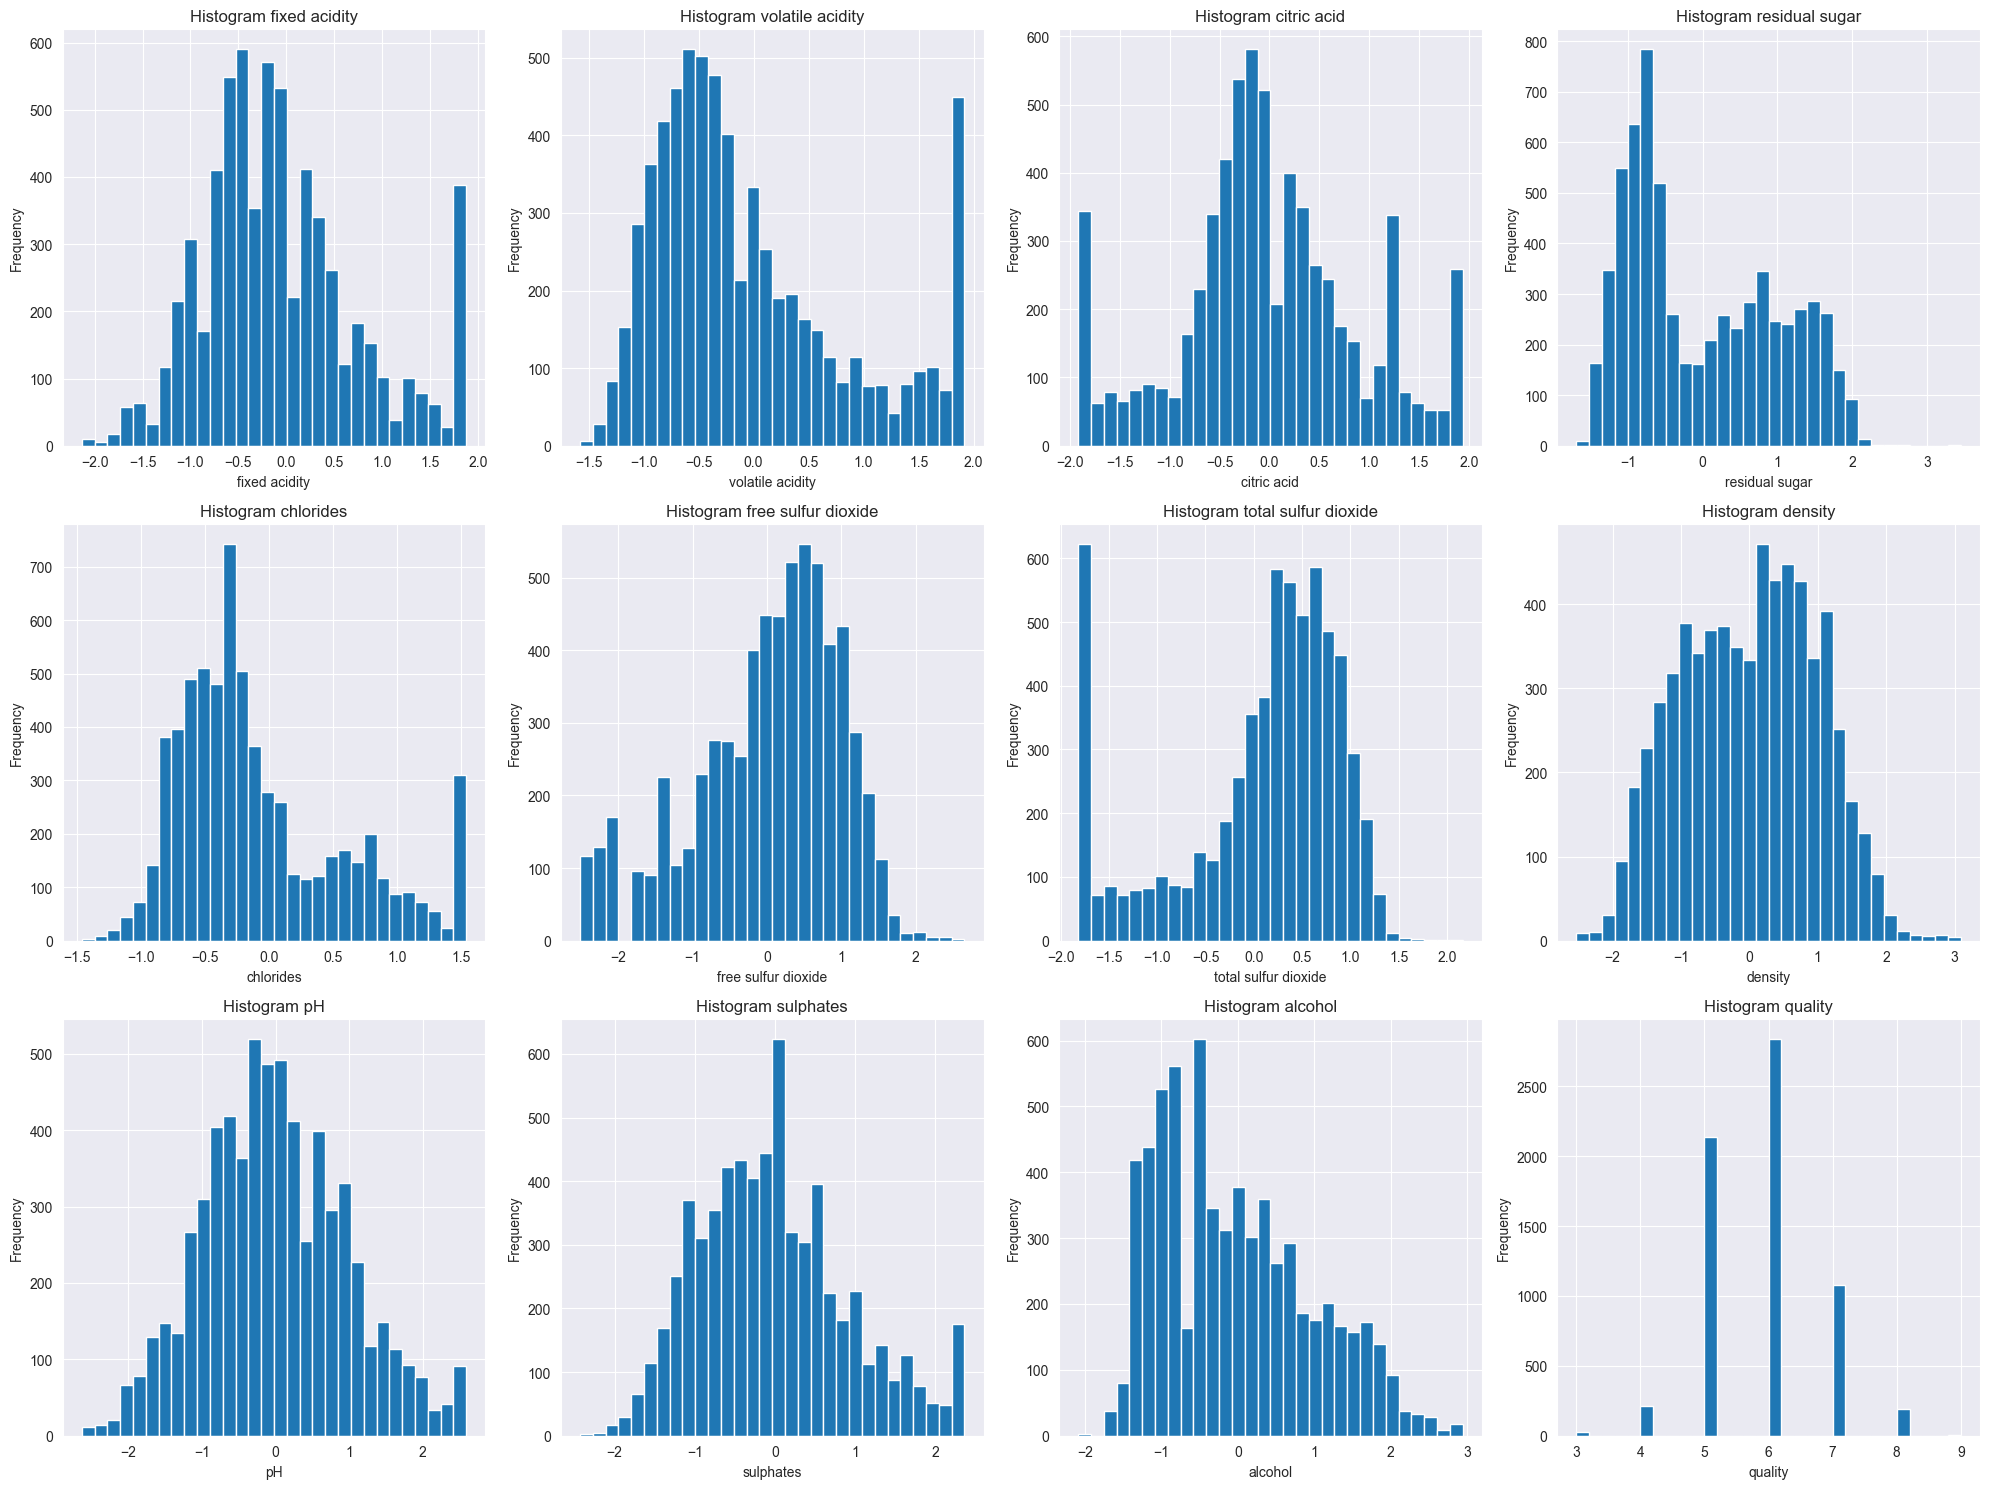

In [60]:
numerical_cols = df_Cleaned.select_dtypes(include='number').columns

n_features = len(numerical_cols)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df_Cleaned[col], bins=30)
    axes[i].set_title(f"Histogram {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Machine Learning Training

## Scaling

In [61]:
y = df_Cleaned['quality']
Y_data = y.values.reshape(-1, 1)

Scalers = MinMaxScaler()
# Fit dan Transform data
Y_scaled = Scalers.fit_transform(Y_data)

# 4. Masukkan Hasil ke DataFrame
y = Y_scaled
X= df_Cleaned.drop(['quality'], axis=1)

## Splitting

In [62]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Training

In [63]:
if len(y_train.shape) > 1:
    y_train = np.ravel(y_train)

models = {
    'lr': LR(),
    'svr': SVR(),
    'rf': RF(),
    'knn': KNN(),
    'xgb': XGBS()
}

models_name = {
    'lr': 'Linear Regression',
    'svr': 'Support Vector',
    'rf': 'Random Forest',
    'knn': 'Nearest Neighbors',
    'xgb': 'XGBoost Regressor'
}

results = {}

for key, model in models.items():
    model_trained, RMSE, MSE, MAE = trains(
        models_name[key],
        model,
        x_train,
        y_train
    )

    results[key] = {
        'model': model_trained,
        'rmse': RMSE,
        'mse': MSE,
        'mae': MAE
    }

Model: Linear Regression    | RMSE:     0.11 | MSE:     0.01 | MAE:     0.09
Model: Support Vector       | RMSE:     0.11 | MSE:     0.01 | MAE:     0.09
Model: Random Forest        | RMSE:     0.09 | MSE:     0.01 | MAE:     0.07
Model: Nearest Neighbors    | RMSE:     0.11 | MSE:     0.01 | MAE:     0.08
Model: XGBoost Regressor    | RMSE:     0.10 | MSE:     0.01 | MAE:     0.07


## Results

In [64]:
results

{'lr': {'model': LinearRegression(),
  'rmse': 0.11454234023552232,
  'mse': 0.013119947706630155,
  'mae': 0.09072453246586004},
 'svr': {'model': SVR(),
  'rmse': 0.10716582807925945,
  'mse': 0.011484514707913392,
  'mae': 0.08635302466740659},
 'rf': {'model': RandomForestRegressor(),
  'rmse': 0.0935735461923323,
  'mse': 0.008756008547008545,
  'mae': 0.06726410256410256},
 'knn': {'model': KNeighborsRegressor(),
  'rmse': 0.11263358640443259,
  'mse': 0.012686324786324782,
  'mae': 0.08464102564102564},
 'xgb': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max

## Reverse Scaling

In [65]:
y_test_actual = Scalers.inverse_transform(y_test.reshape(-1,1))
y_test_actual= y_test_actual.flatten().astype(int)

# ML Model Analysis

## Parameter

In [66]:
# To show data based on where data want to be shown
Data_Shown_Start = 400
Data_Shown_End = 600

In [67]:
def ModelEvaluationResults(
    results,
    model_key,
    x_test,
    y_test,
    scaler,
    show_plot=True
):
    model = results[model_key]['model']

    y_pred = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    y_pred = np.round(y_pred).astype(int)

    y_test_1d = y_test_actual

    # DATAFRAME Comparison test vs ml predictions
    df = pd.DataFrame({
        'Actual': y_test_1d,
        'Predicted': y_pred
    })

    df['Dif'] = np.abs(df['Actual'] - df['Predicted'])
    df['Correct'] = (df['Dif'] == 0).astype(int)
    df['Wrong'] = 1 - df['Correct']

    total_data = len(df)
    CorrectTotal = int(df['Correct'].sum())
    WrongTotal = int(df['Wrong'].sum())

    print(f"\nModel: {model_key.upper()}")
    print(f"Total data test : {total_data}")
    print(f"Total Correct     : {CorrectTotal}")
    print(f"Total Wrong     : {WrongTotal}")

    # Checking for wrong predictions of by 1 error
    Diff_1 = df[df['Dif'] == 1].copy()
    Diff_1['status'] = np.where(
        Diff_1['Predicted'] > Diff_1['Actual'],
        'Upper',
        'Lower'
    )

    status_summary = Diff_1.groupby('status').size().to_dict()

    print("\nPrediction Distributions (Dif = 1):")
    print(status_summary)

    # PLOT Visualizations
    df = df[Data_Shown_Start:Data_Shown_End]

    if show_plot:
        plt.figure(figsize=(14, 6))

        plt.plot(
            df.index,
            df['Actual'],
            label='Actual',
            color='green',
            linewidth=2
        )

        plt.plot(
            df.index,
            df['Predicted'],
            label='Predicted',
            color='blue',
            alpha=0.7
        )

        salah_idx = df[df['Dif'] != 0].index

        plt.scatter(
            salah_idx,
            df.loc[salah_idx, 'Predicted'],
            color='red',
            label='Mis-prediction',
            s=25
        )

        plt.title(f'Prediction vs Actual — {model_key.upper()}')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Wine Quality')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Evaluation
    class_per_evaluation = (
        df.groupby('Actual')
          .agg(
              CorrectTotal=('Correct', 'sum'),
              WrongTotal=('Wrong', 'sum')
          )
          .reset_index()
    )
    # RINGKASAN
    Summary = {
        'CorrectTotal': CorrectTotal,
        'WrongTotal': WrongTotal,
        'Difference': int(df['Dif'].sum())
    }

    return {
        'dfPredictions': df,
        'status_diff_1': status_summary,
        'class_per_evaluation': class_per_evaluation,
        'Summary': Summary
    }

## Analysis


Model: LR
Total data test : 1300
Total Correct     : 805
Total Wrong     : 495

Prediction Distributions (Dif = 1):
{'Lower': 132, 'Upper': 320}


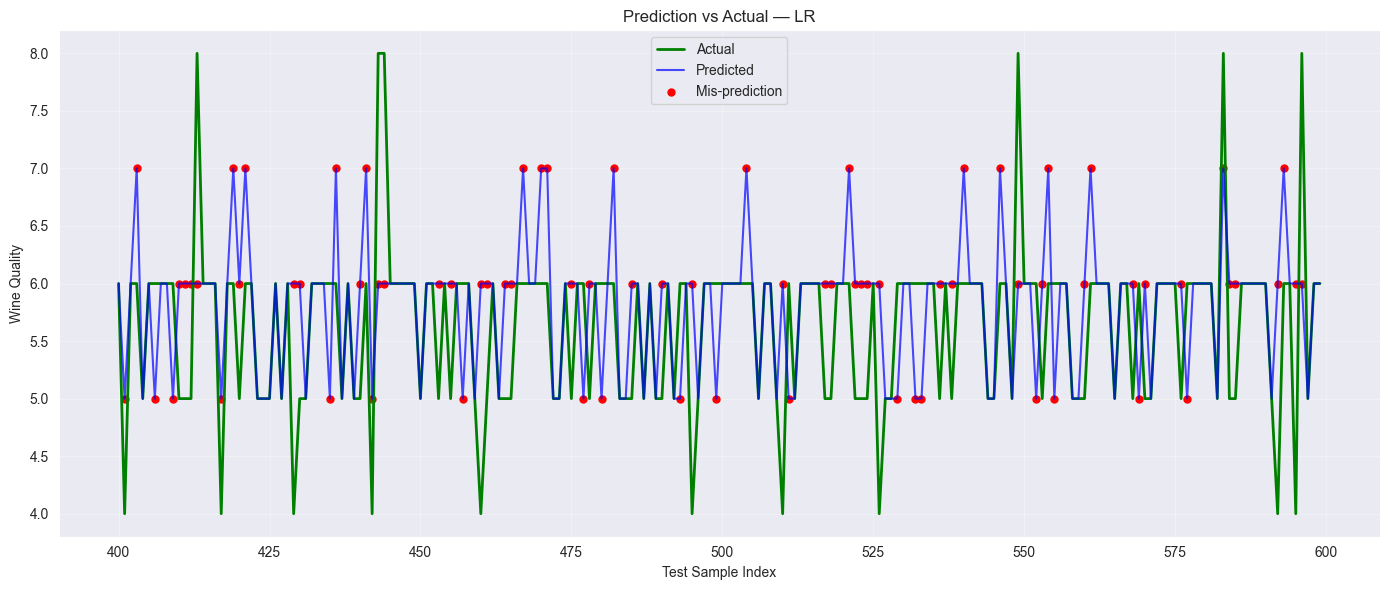

In [68]:
temp = ModelEvaluationResults(results, 'lr', x_test, y_test, Scalers)


Model: SVR
Total data test : 1300
Total Correct     : 762
Total Wrong     : 538

Prediction Distributions (Dif = 1):
{'Lower': 154, 'Upper': 354}


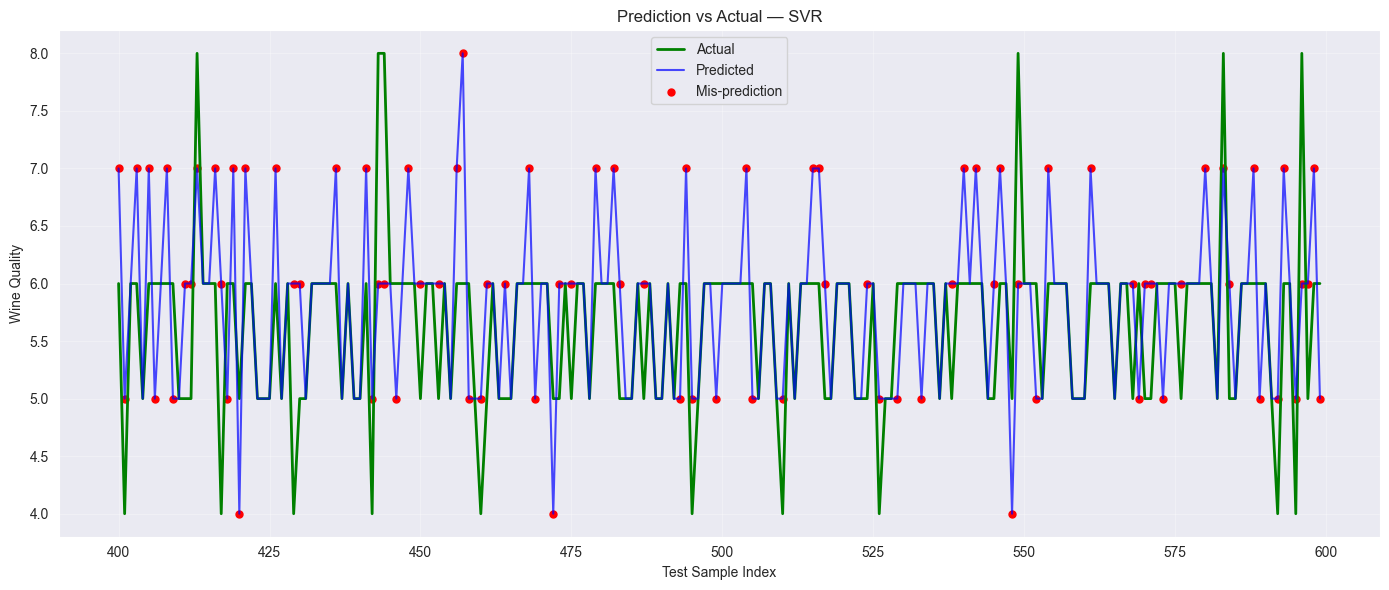

{'dfPredictions':      Actual  Predicted  Dif  Correct  Wrong
 400       6          7    1        0      1
 401       4          5    1        0      1
 402       6          6    0        1      0
 403       6          7    1        0      1
 404       5          5    0        1      0
 ..      ...        ...  ...      ...    ...
 595       4          5    1        0      1
 596       8          6    2        0      1
 597       5          6    1        0      1
 598       6          7    1        0      1
 599       6          5    1        0      1
 
 [200 rows x 5 columns],
 'status_diff_1': {'Lower': 154, 'Upper': 354},
 'class_per_evaluation':    Actual  CorrectTotal  WrongTotal
 0       4             0          10
 1       5            39          24
 2       6            76          45
 3       8             0           6,
 'Summary': {'CorrectTotal': 762, 'WrongTotal': 538, 'Difference': 92}}

In [69]:
ModelEvaluationResults(results, 'svr', x_test, y_test, Scalers)


Model: RF
Total data test : 1300
Total Correct     : 891
Total Wrong     : 409

Prediction Distributions (Dif = 1):
{'Lower': 97, 'Upper': 287}


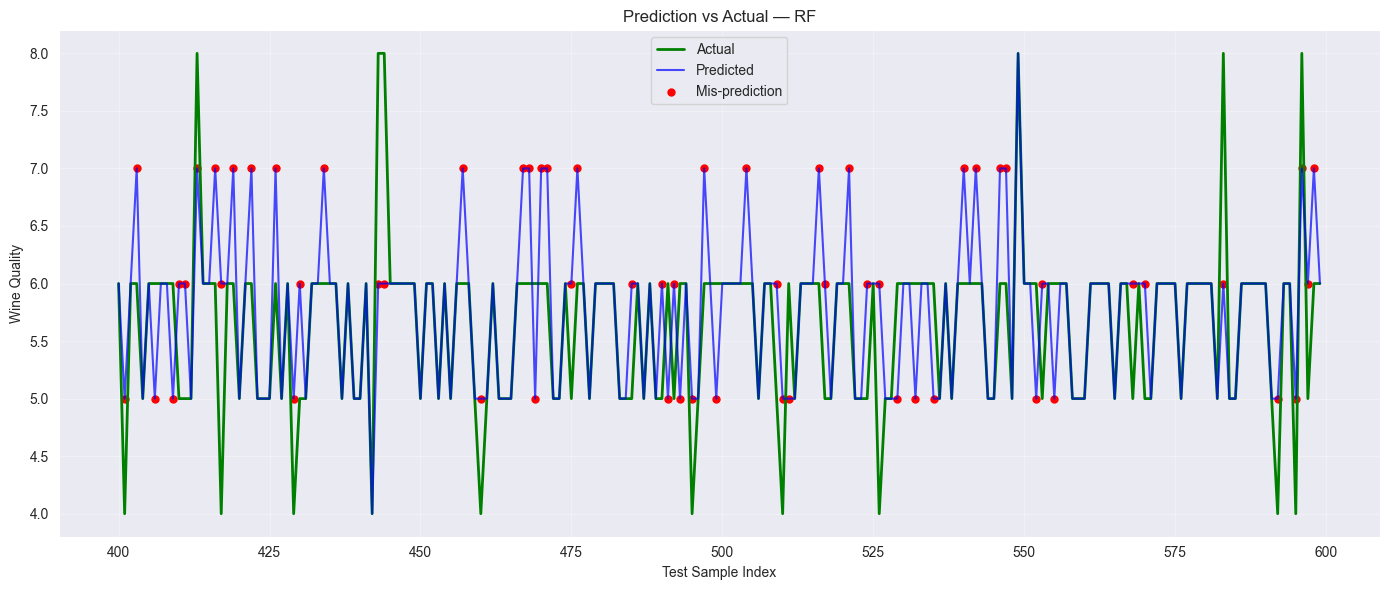

{'dfPredictions':      Actual  Predicted  Dif  Correct  Wrong
 400       6          6    0        1      0
 401       4          5    1        0      1
 402       6          6    0        1      0
 403       6          7    1        0      1
 404       5          5    0        1      0
 ..      ...        ...  ...      ...    ...
 595       4          5    1        0      1
 596       8          7    1        0      1
 597       5          6    1        0      1
 598       6          7    1        0      1
 599       6          6    0        1      0
 
 [200 rows x 5 columns],
 'status_diff_1': {'Lower': 97, 'Upper': 287},
 'class_per_evaluation':    Actual  CorrectTotal  WrongTotal
 0       4             1           9
 1       5            49          14
 2       6            88          33
 3       8             1           5,
 'Summary': {'CorrectTotal': 891, 'WrongTotal': 409, 'Difference': 66}}

In [70]:
ModelEvaluationResults(results, 'rf', x_test, y_test, Scalers)


Model: KNN
Total data test : 1300
Total Correct     : 742
Total Wrong     : 558

Prediction Distributions (Dif = 1):
{'Lower': 159, 'Upper': 359}


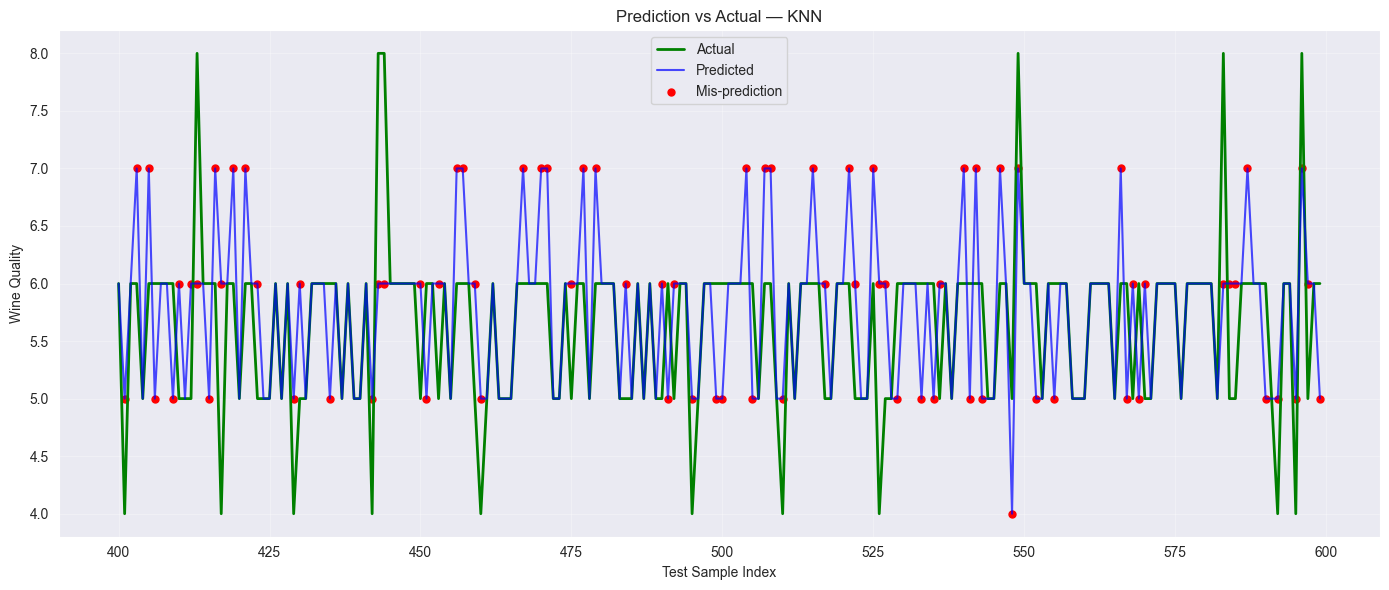

{'dfPredictions':      Actual  Predicted  Dif  Correct  Wrong
 400       6          6    0        1      0
 401       4          5    1        0      1
 402       6          6    0        1      0
 403       6          7    1        0      1
 404       5          5    0        1      0
 ..      ...        ...  ...      ...    ...
 595       4          5    1        0      1
 596       8          7    1        0      1
 597       5          6    1        0      1
 598       6          6    0        1      0
 599       6          5    1        0      1
 
 [200 rows x 5 columns],
 'status_diff_1': {'Lower': 159, 'Upper': 359},
 'class_per_evaluation':    Actual  CorrectTotal  WrongTotal
 0       4             0          10
 1       5            42          21
 2       6            78          43
 3       8             0           6,
 'Summary': {'CorrectTotal': 742, 'WrongTotal': 558, 'Difference': 86}}

In [71]:
ModelEvaluationResults(results, 'knn', x_test, y_test, Scalers)


Model: XGB
Total data test : 1300
Total Correct     : 847
Total Wrong     : 453

Prediction Distributions (Dif = 1):
{'Lower': 132, 'Upper': 290}


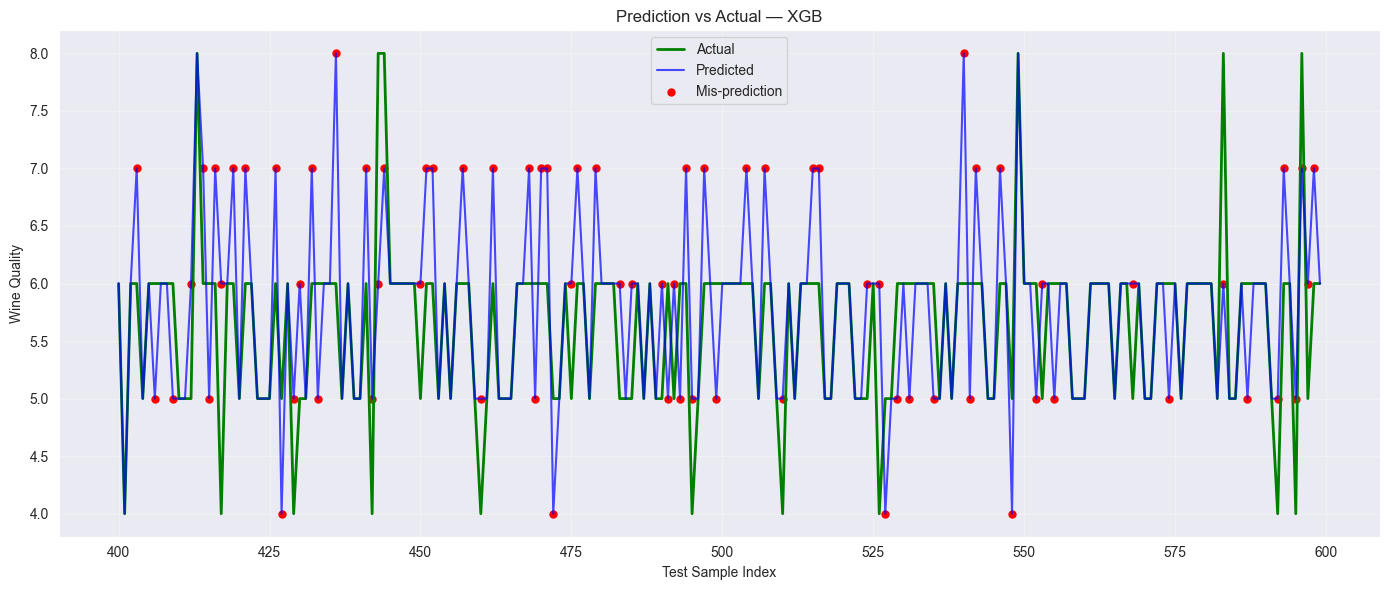

{'dfPredictions':      Actual  Predicted  Dif  Correct  Wrong
 400       6          6    0        1      0
 401       4          4    0        1      0
 402       6          6    0        1      0
 403       6          7    1        0      1
 404       5          5    0        1      0
 ..      ...        ...  ...      ...    ...
 595       4          5    1        0      1
 596       8          7    1        0      1
 597       5          6    1        0      1
 598       6          7    1        0      1
 599       6          6    0        1      0
 
 [200 rows x 5 columns],
 'status_diff_1': {'Lower': 132, 'Upper': 290},
 'class_per_evaluation':    Actual  CorrectTotal  WrongTotal
 0       4             1           9
 1       5            47          16
 2       6            76          45
 3       8             2           4,
 'Summary': {'CorrectTotal': 847, 'WrongTotal': 453, 'Difference': 80}}

In [72]:
ModelEvaluationResults(results, 'xgb', x_test, y_test, Scalers)

In [73]:
def plot_model_accuracy(evaluation_dict, title):

    data_plot = []

    for model_key, eval_data in evaluation_dict.items():
        Summary = eval_data['Summary']

        data_plot.append({
            'Model': model_key.upper(),
            'Correct': Summary['CorrectTotal'],
            'Wrong': Summary['WrongTotal']
        })

    df_plot = pd.DataFrame(data_plot)

    x = np.arange(len(df_plot))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, df_plot['Correct'], width, label='Correct')
    plt.bar(x + width/2, df_plot['Wrong'], width, label='Wrong')

    plt.xticks(x, df_plot['Model'])
    plt.ylabel('Total Data')
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_plot

In [74]:
Evaluation = {
    'lr': ModelEvaluationResults(results, 'lr', x_test, y_test, Scalers, show_plot=False),
    'svr': ModelEvaluationResults(results, 'svr', x_test, y_test, Scalers, show_plot=False),
    'rf': ModelEvaluationResults(results, 'rf', x_test, y_test, Scalers, show_plot=False),
    'knn': ModelEvaluationResults(results, 'knn', x_test, y_test, Scalers, show_plot=False),
    'xgb': ModelEvaluationResults(results, 'xgb', x_test, y_test, Scalers, show_plot=False),
}


Model: LR
Total data test : 1300
Total Correct     : 805
Total Wrong     : 495

Prediction Distributions (Dif = 1):
{'Lower': 132, 'Upper': 320}

Model: SVR
Total data test : 1300
Total Correct     : 762
Total Wrong     : 538

Prediction Distributions (Dif = 1):
{'Lower': 154, 'Upper': 354}

Model: RF
Total data test : 1300
Total Correct     : 891
Total Wrong     : 409

Prediction Distributions (Dif = 1):
{'Lower': 97, 'Upper': 287}

Model: KNN
Total data test : 1300
Total Correct     : 742
Total Wrong     : 558

Prediction Distributions (Dif = 1):
{'Lower': 159, 'Upper': 359}

Model: XGB
Total data test : 1300
Total Correct     : 847
Total Wrong     : 453

Prediction Distributions (Dif = 1):
{'Lower': 132, 'Upper': 290}


In [75]:
def plot_accuracy_models(evaluasi_dict, title='Accuracy Comparison'):

    models = []
    correct = []
    wrong = []

    for model_key, eval_data in evaluasi_dict.items():
        Summary = eval_data['Summary']

        models.append(model_key.upper())
        correct.append(Summary['CorrectTotal'])
        wrong.append(Summary['WrongTotal'])

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, correct, width, label='Correct')
    plt.bar(x + width/2, wrong, width, label='Wrong')

    plt.xticks(x, models)
    plt.ylabel('Total Data')
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

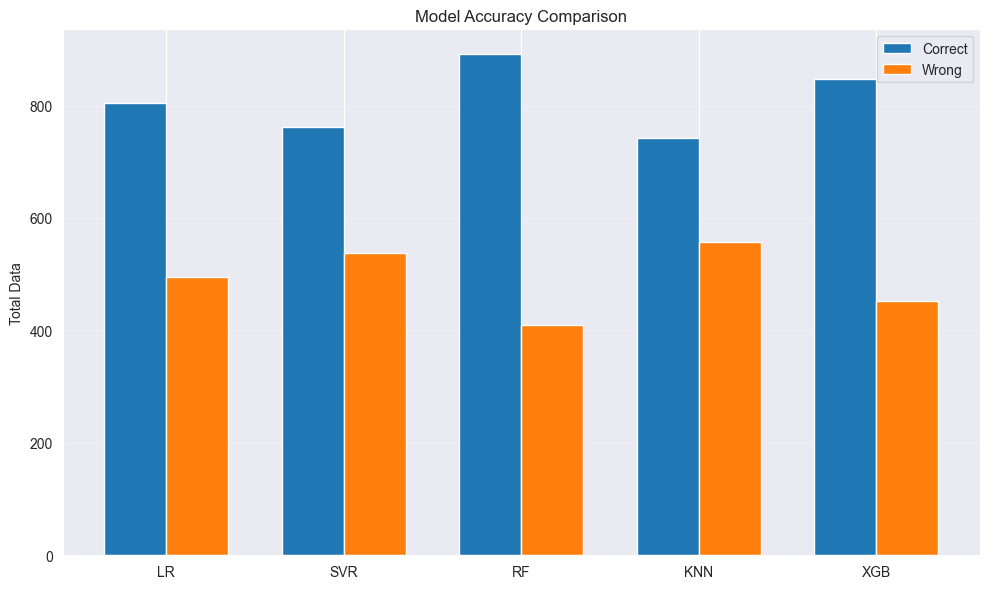

In [76]:
plot_accuracy_models(
    Evaluation,
    title='Model Accuracy Comparison'
)

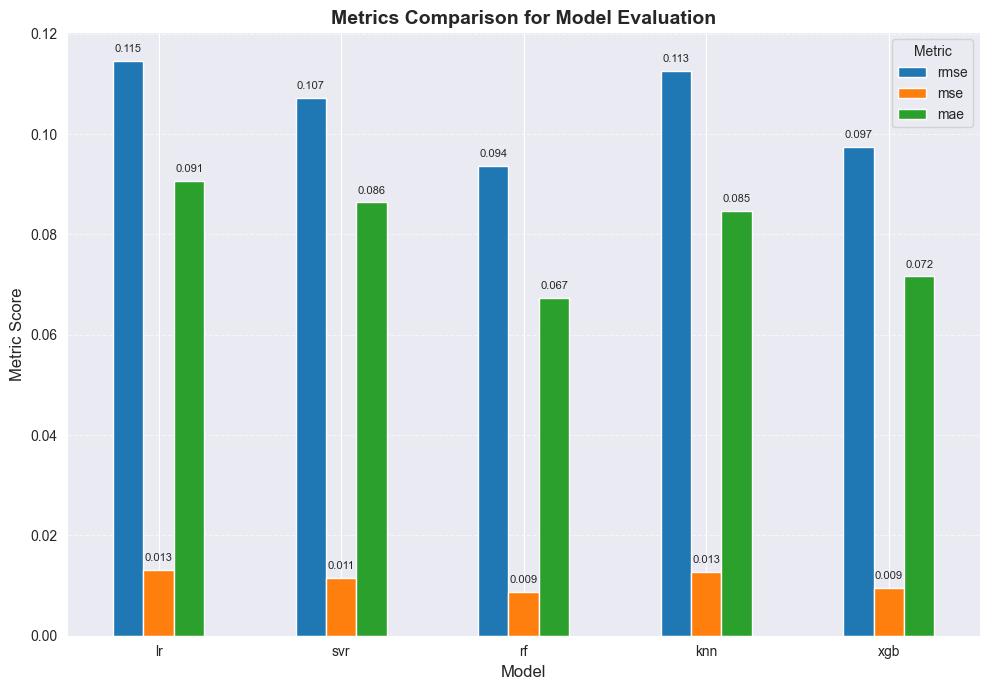

In [77]:
df_results = pd.DataFrame.from_dict(results, orient='index').drop(columns=['model'])

plt.figure(figsize=(10, 7))

ax = df_results.plot(kind='bar', figsize=(10, 7), rot=0, ax=plt.gca())

# Plot
plt.title('Metrics Comparison for Model Evaluation', fontsize=14, fontweight='bold')
plt.ylabel('Metric Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=8)

plt.tight_layout()
plt.show()

In [78]:
importances = results['rf']['model'].feature_importances_.round(2)
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
print(feature_imp_df)

                 Feature  Gini Importance
10               alcohol             0.25
1       volatile acidity             0.12
5    free sulfur dioxide             0.10
9              sulphates             0.08
4              chlorides             0.07
6   total sulfur dioxide             0.07
3         residual sugar             0.07
8                     pH             0.07
2            citric acid             0.06
7                density             0.06
0          fixed acidity             0.05


# Model Tuning

## Hyperparameter Tuning

In [79]:
param_grids = {

    'lr': {
        'model': LR(),
        'params': {
            'fit_intercept': [True, False],
            'positive': [False, True]
        }
    },

    'svr': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.5]
        }
    },

    'rf': {
        'model': RF(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    'knn': {
        'model': KNN(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # Manhattan vs Euclidean
        }
    },

    'xgb': {
        'model': XGBS(
            objective='reg:squarederror',
            random_state=42
        ),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

In [80]:
tuned_results = {}

for key, cfg in param_grids.items():
    print(f"\nTuning model: {models_name[key]}")

    grid = GridSearchCV(
        estimator=cfg['model'],
        param_grid=cfg['params'],
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(x_train, y_train)

    tuned_results[key] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_rmse': -grid.best_score_
    }

    print(f"Best RMSE : {-grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")


Tuning model: Linear Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best RMSE : 0.1235
Best Params: {'fit_intercept': True, 'positive': False}

Tuning model: Support Vector
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RMSE : 0.1157
Best Params: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}

Tuning model: Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RMSE : 0.1052
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuning model: Nearest Neighbors
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RMSE : 0.1061
Best Params: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

Tuning model: XGBoost Regressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best RMSE : 0.1060
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


## ReTraining

In [81]:
final_models = {}
final_metrics = {}

for key in models:
    print(f"\nReTraining model: {models_name[key]}")

    base_model = models[key]
    best_params = tuned_results[key]['best_params']

    tuned_model = base_model.__class__(**best_params)
    tuned_model.fit(x_train, y_train)


    y_pred = tuned_model.predict(x_test)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)

    final_models[key] = tuned_model
    final_metrics[key] = {
        'rmse': rmse,
        'mse': mse,
        'mae': mae
    }

    results_final = {}

    for key in final_models:
        results_final[key] = {
            'model': final_models[key],
            'rmse': final_metrics[key]['rmse'],
            'mse':  final_metrics[key]['mse'],
            'mae':  final_metrics[key]['mae']
        }

    print(
        f"RMSE : {rmse:.4f} | "
        f"MSE  : {mse:.4f} | "
        f"MAE  : {mae:.4f}"
    )


ReTraining model: Linear Regression
RMSE : 0.1145 | MSE  : 0.0131 | MAE  : 0.0907

ReTraining model: Support Vector
RMSE : 0.1078 | MSE  : 0.0116 | MAE  : 0.0819

ReTraining model: Random Forest
RMSE : 0.0936 | MSE  : 0.0088 | MAE  : 0.0675

ReTraining model: Nearest Neighbors
RMSE : 0.0973 | MSE  : 0.0095 | MAE  : 0.0632

ReTraining model: XGBoost Regressor
RMSE : 0.0958 | MSE  : 0.0092 | MAE  : 0.0696


# Tuning Results Analysis

## Parameter

In [82]:
Data_Shown_Start = 400
Data_Shown_End = 600

## Analysis


Model: LR
Total data test : 1300
Total Correct     : 805
Total Wrong     : 495

Prediction Distributions (Dif = 1):
{'Lower': 132, 'Upper': 320}


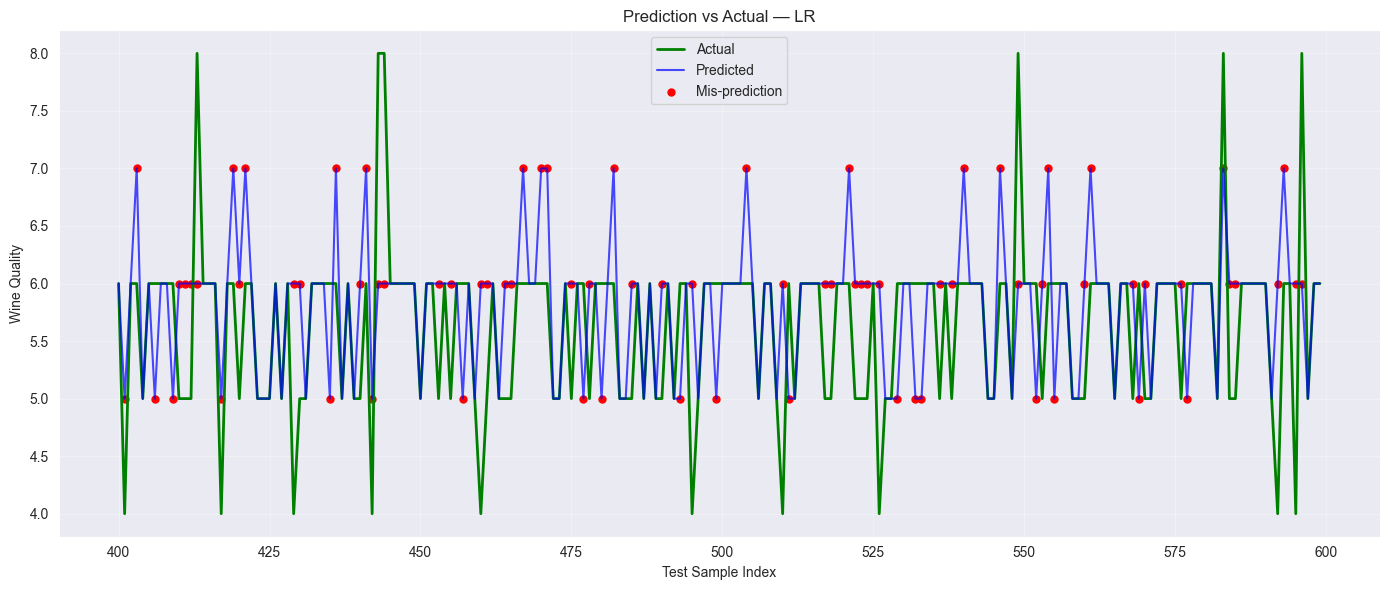


Model: SVR
Total data test : 1300
Total Correct     : 848
Total Wrong     : 452

Prediction Distributions (Dif = 1):
{'Lower': 133, 'Upper': 289}


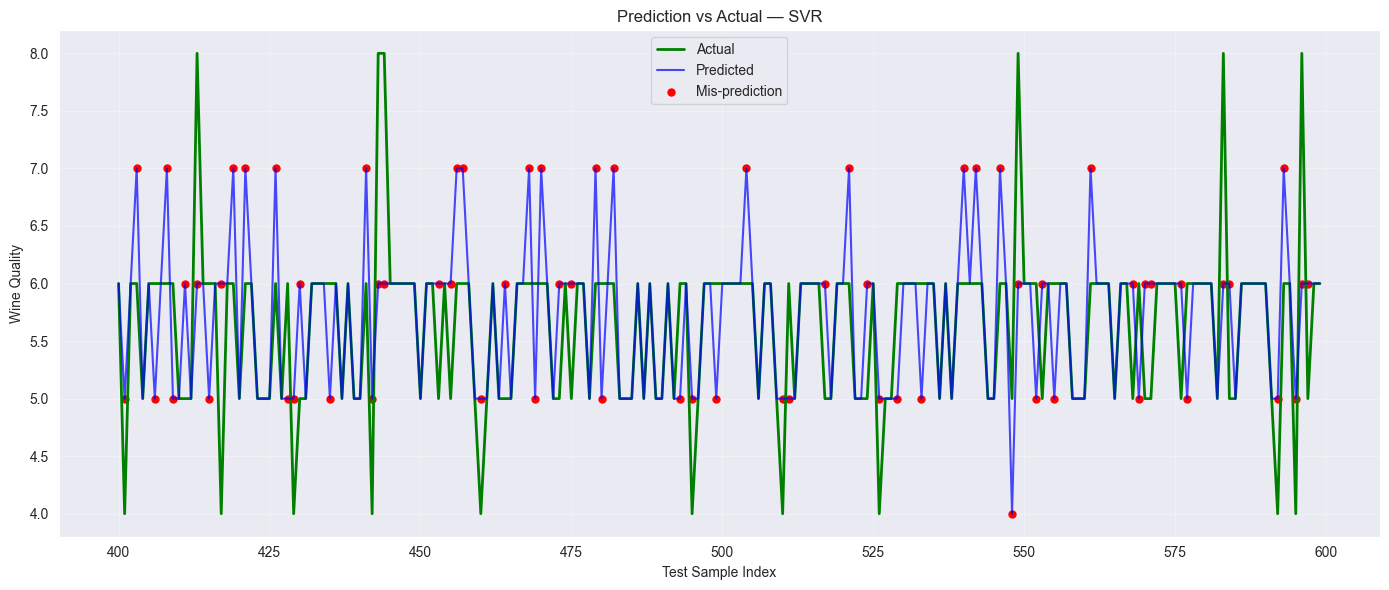


Model: RF
Total data test : 1300
Total Correct     : 877
Total Wrong     : 423

Prediction Distributions (Dif = 1):
{'Lower': 106, 'Upper': 293}


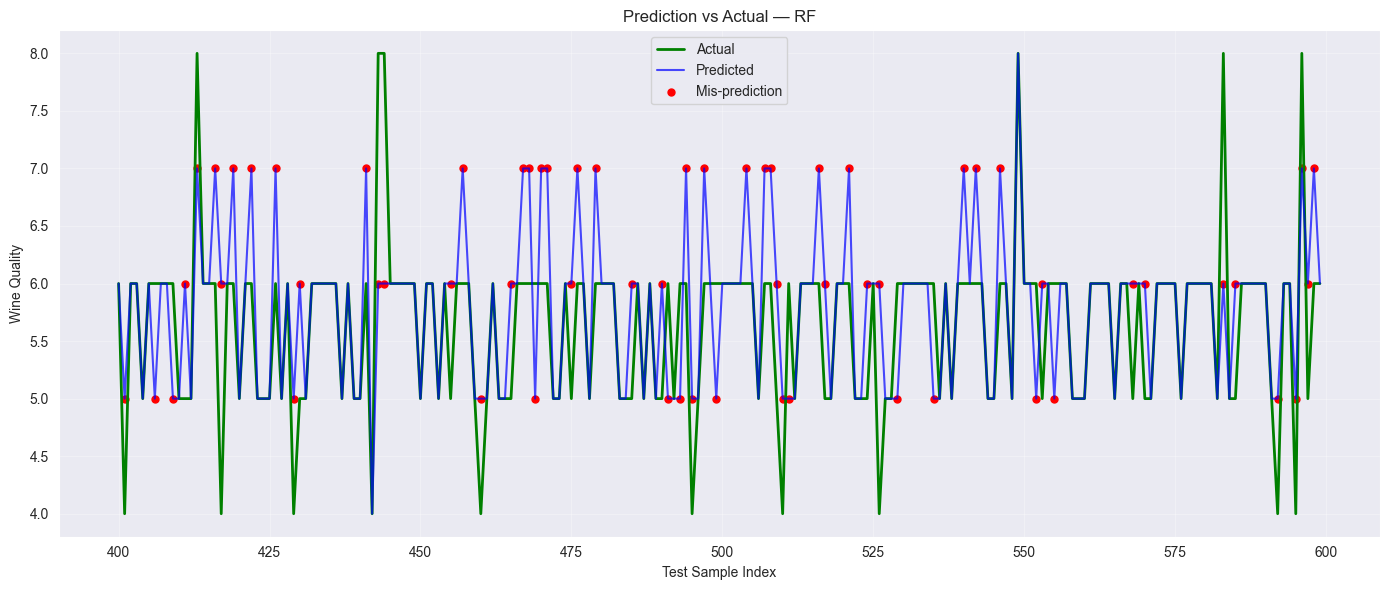


Model: KNN
Total data test : 1300
Total Correct     : 845
Total Wrong     : 455

Prediction Distributions (Dif = 1):
{'Lower': 106, 'Upper': 316}


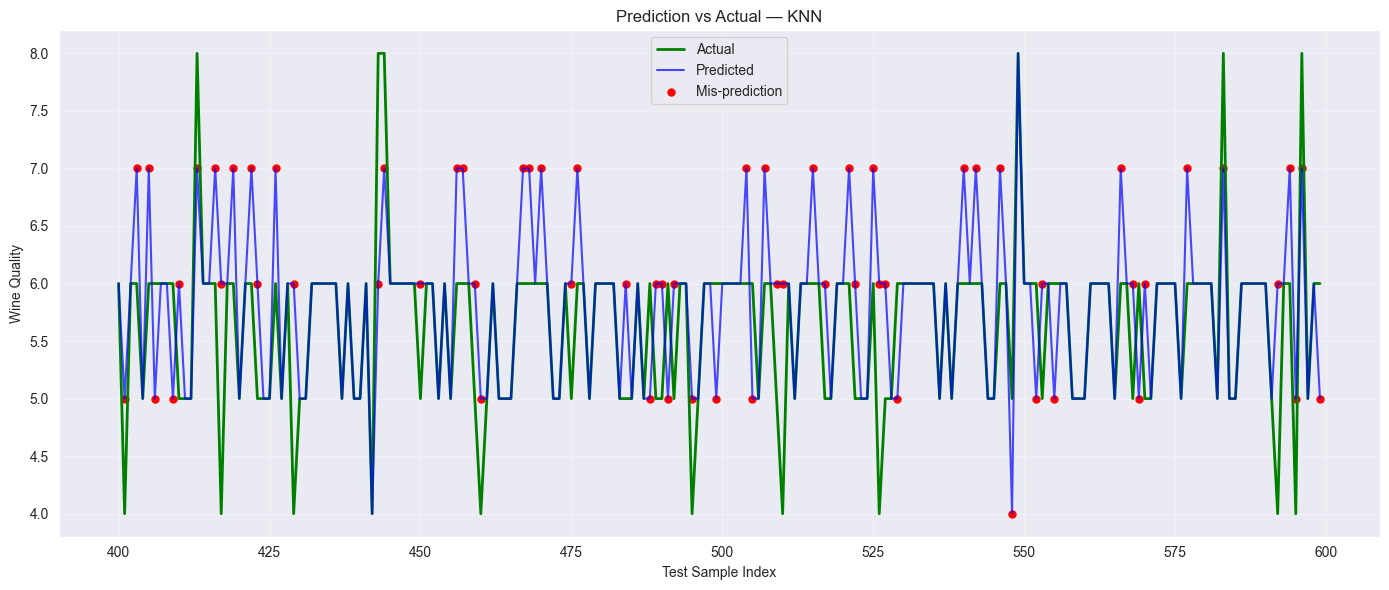


Model: XGB
Total data test : 1300
Total Correct     : 853
Total Wrong     : 447

Prediction Distributions (Dif = 1):
{'Lower': 130, 'Upper': 289}


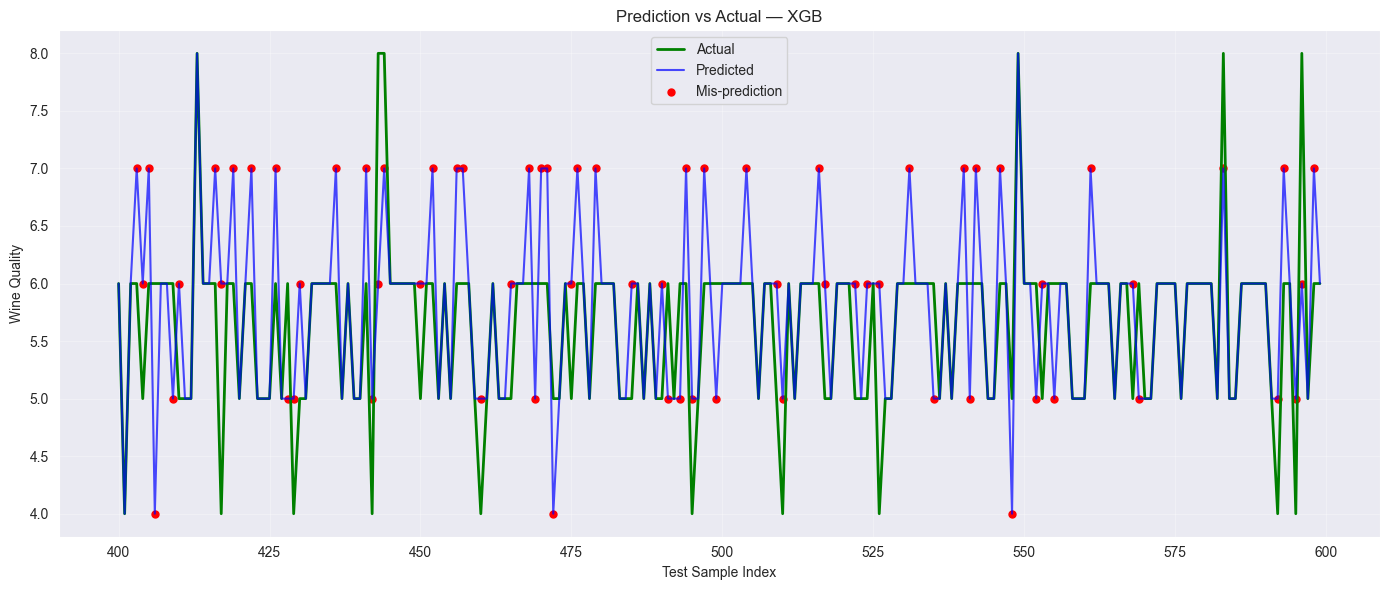

In [83]:
Evaluation = {}

for key in results_final:
    Evaluation[key] = ModelEvaluationResults(
        results=results_final,
        model_key=key,
        x_test=x_test,
        y_test=y_test,
        scaler=Scalers,
        show_plot=True
    )

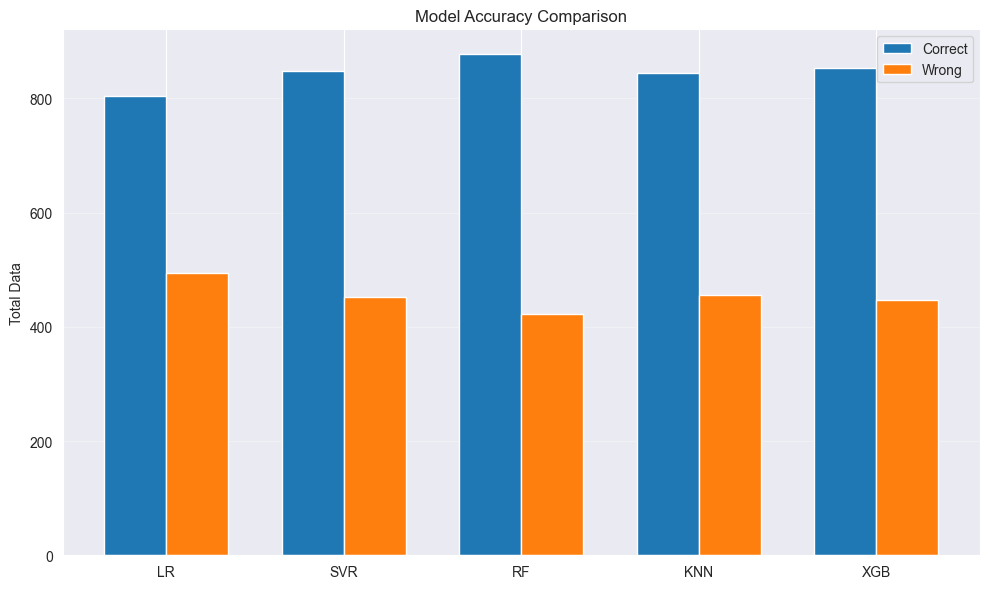

In [84]:
plot_accuracy_models(
    Evaluation,
    title='Model Accuracy Comparison'
)


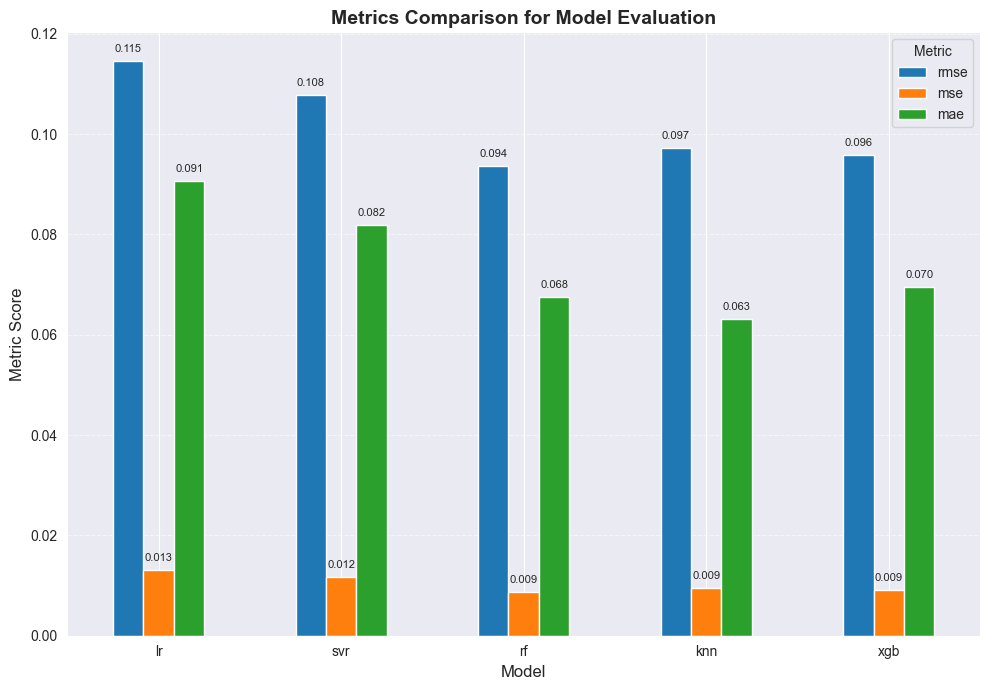

In [85]:
df_results_tuned = (
    pd.DataFrame.from_dict(results_final, orient='index')
      .drop(columns=['model'])
)

plt.figure(figsize=(10, 7))

ax = df_results_tuned.plot(
    kind='bar',
    figsize=(10, 7),
    rot=0,
    ax=plt.gca()
)

plt.title(
    'Metrics Comparison for Model Evaluation',
    fontsize=14,
    fontweight='bold'
)
plt.ylabel('Metric Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize=8
    )

plt.tight_layout()
plt.show()

# Conclusion

## Results Comparison

In [86]:
Data_Shown_Start = 400
Data_Shown_End = 600

def plot_compare_before_after(
    results_before,
    results_after,
    model_names,
    x_test,
    y_test_actual,
    scaler
):
    models = list(model_names.keys())
    n_models = len(models)

    fig, axes = plt.subplots(
        nrows=n_models,
        ncols=2,
        figsize=(18, 4 * n_models),
        sharex=False,
        sharey=True
    )

    x_index = np.arange(Data_Shown_Start, Data_Shown_End)
    y_test_visual = y_test_actual[Data_Shown_Start:Data_Shown_End]

    for i, key in enumerate(models):

        #BEFORE
        model_before = results_before[key]['model']
        y_pred_before = model_before.predict(x_test)
        y_pred_before = scaler.inverse_transform(
            y_pred_before.reshape(-1, 1)
        ).ravel()
        y_pred_before = np.round(y_pred_before).astype(int)
        y_pred_before = y_pred_before[Data_Shown_Start:Data_Shown_End]

        ax_left = axes[i, 0]
        ax_left.plot(x_index, y_test_visual, label='Actual', linewidth=2)
        ax_left.plot(x_index, y_pred_before, label='Predicted', alpha=0.8)
        ax_left.set_title(f"{model_names[key]} — Before Tuning")
        ax_left.set_ylabel("Wine Quality")
        ax_left.set_xticks(np.arange(400, 601, 50))
        ax_left.grid(alpha=0.4)

        if i == 0:
            ax_left.legend()

        #AFTER
        model_after = results_after[key]['model']
        y_pred_after = model_after.predict(x_test)
        y_pred_after = scaler.inverse_transform(
            y_pred_after.reshape(-1, 1)
        ).ravel()
        y_pred_after = np.round(y_pred_after).astype(int)
        y_pred_after = y_pred_after[Data_Shown_Start:Data_Shown_End]

        ax_right = axes[i, 1]
        ax_right.plot(x_index, y_test_visual, label='Actual', linewidth=2)
        ax_right.plot(x_index, y_pred_after, label='Predicted', alpha=0.8)
        ax_right.set_title(f"{model_names[key]} — After Tuning")
        ax_right.set_xticks(np.arange(400, 601, 50))
        ax_right.grid(alpha=0.4)

        if i == 0:
            ax_right.legend()

    plt.suptitle(
        "Model Comparison Before and After Hyperparameter Tuning",
        fontsize=16,
        fontweight='bold',
        y=1.02
    )

    plt.tight_layout()
    plt.show()

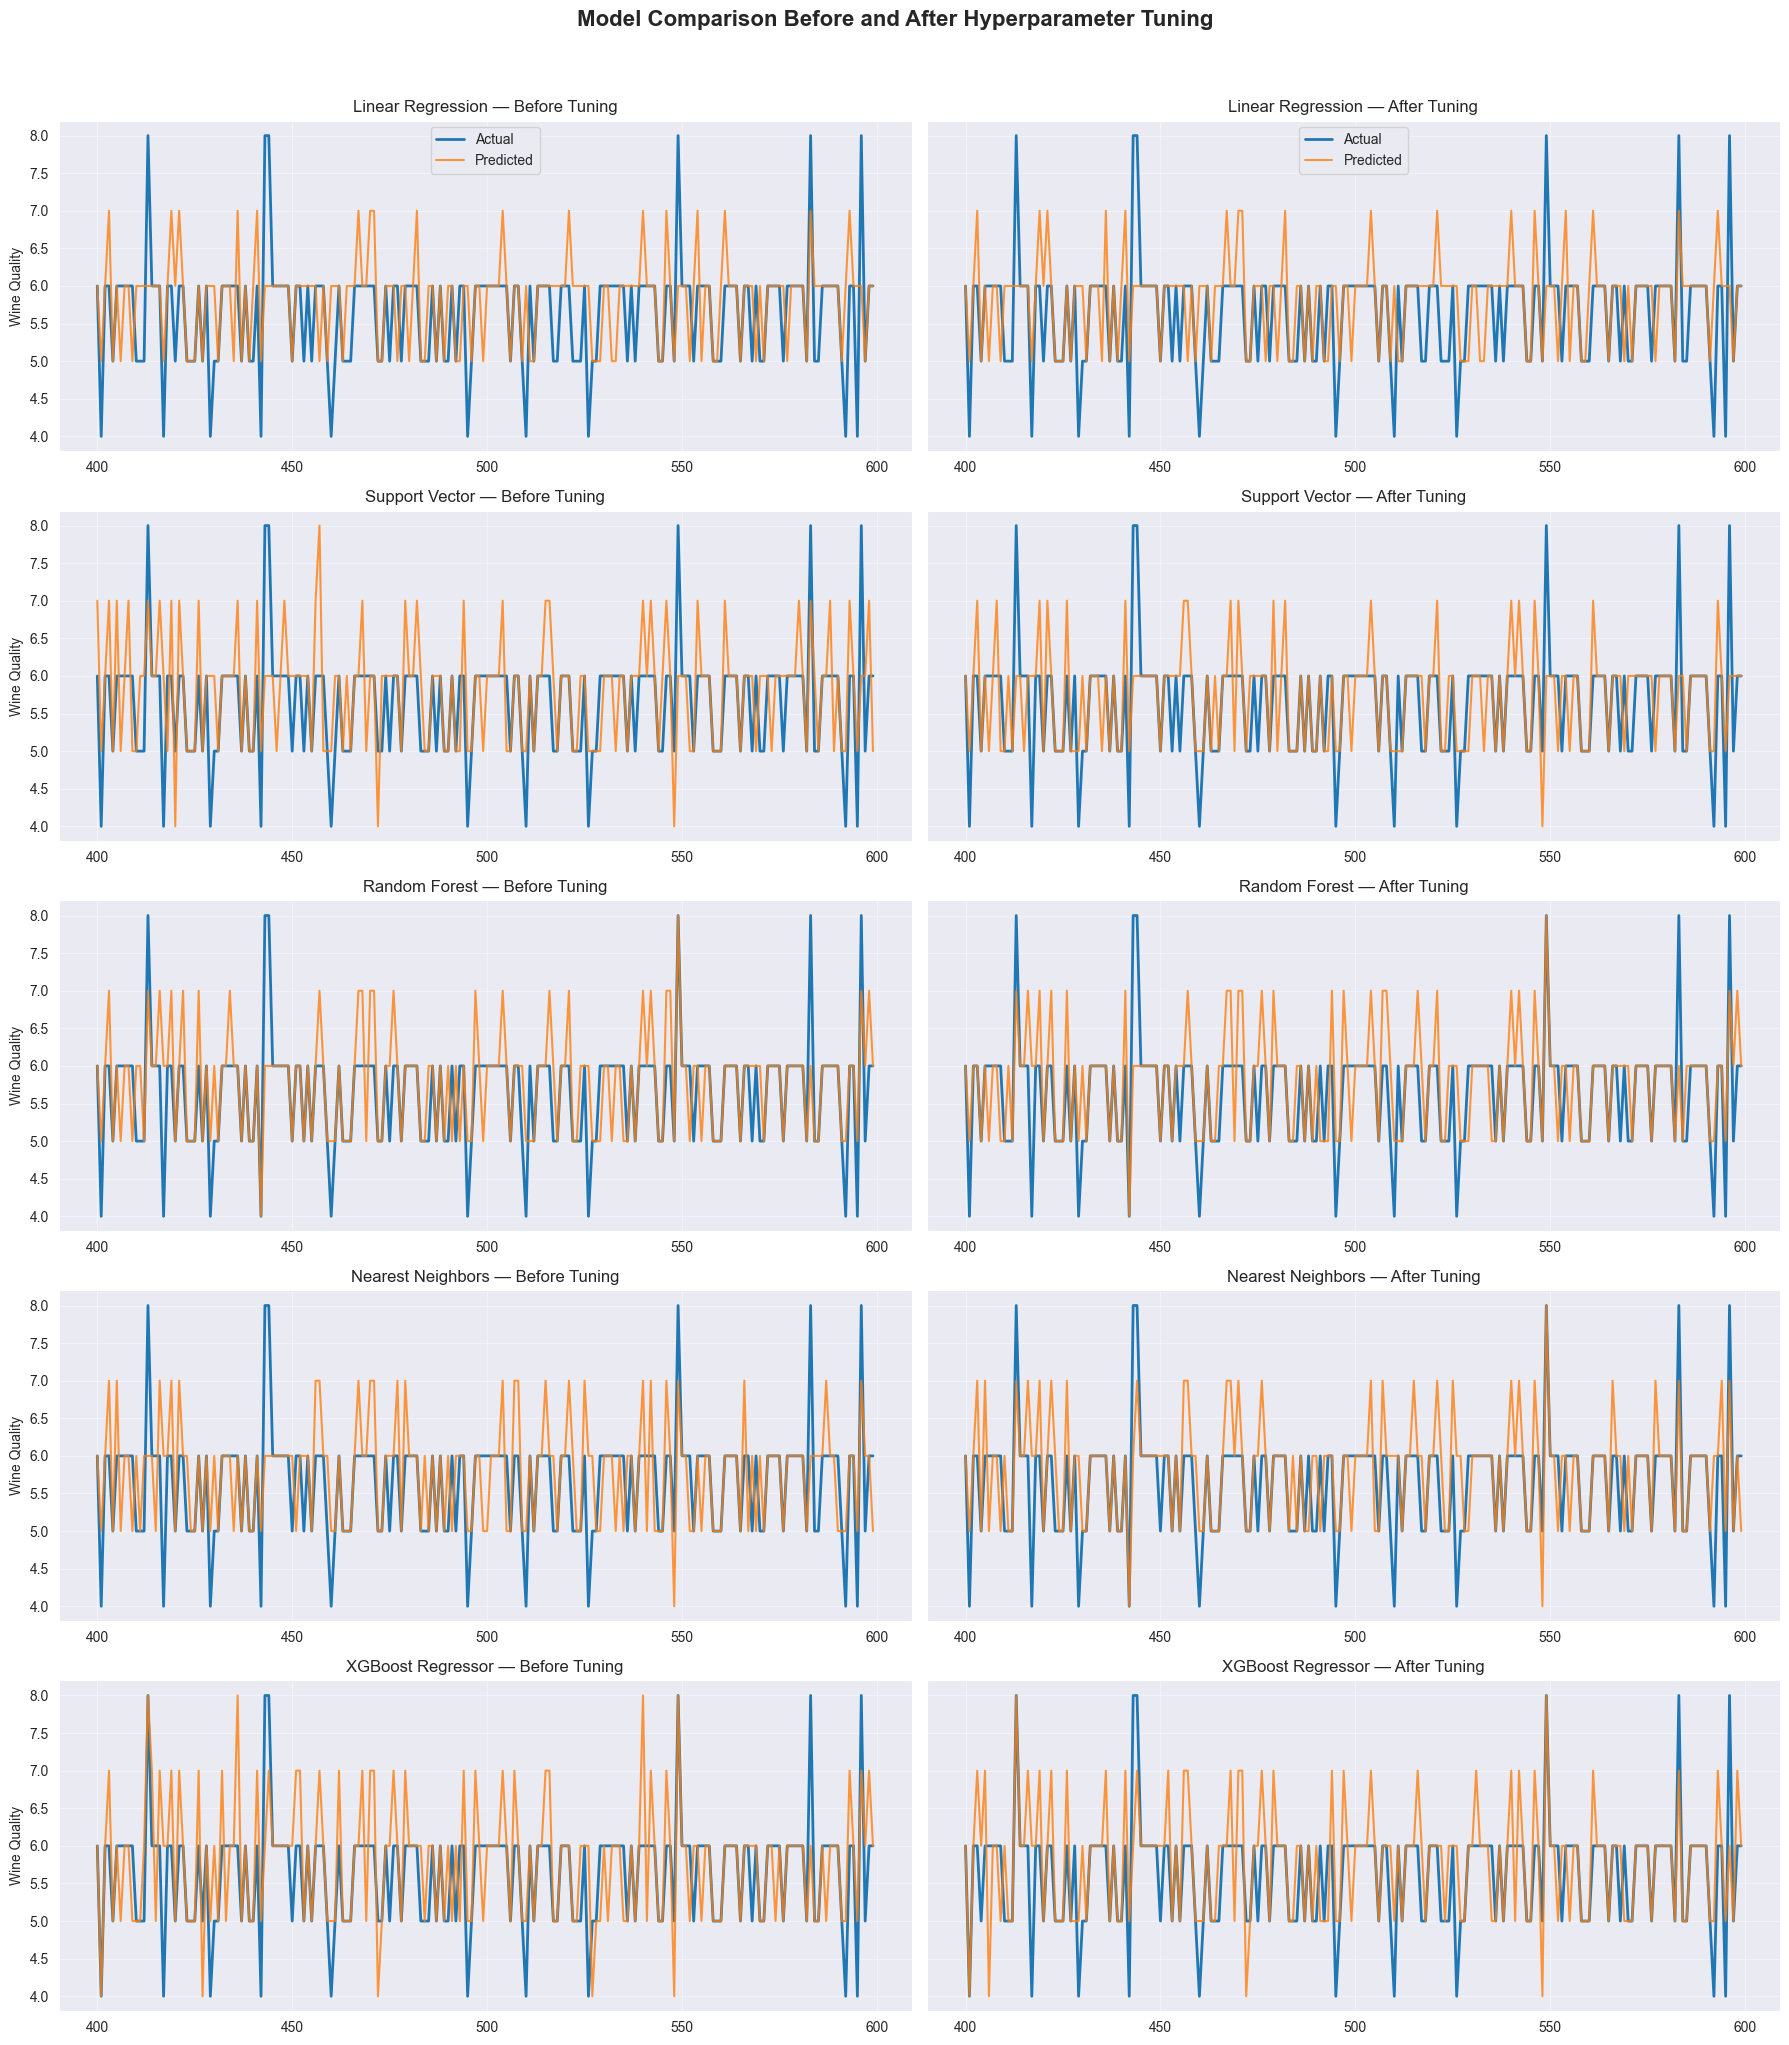

In [87]:
plot_compare_before_after(
    results_before=results,
    results_after=results_final,
    model_names=models_name,
    x_test=x_test,
    y_test_actual=y_test_actual,
    scaler=Scalers
)

In [88]:
def plot_compare_metrics_before_after(
    results_before,
    results_after,
    title_before="Before Hyperparameter Tuning",
    title_after="After Hyperparameter Tuning"
):
    # DATAFRAME
    df_before = (
        pd.DataFrame.from_dict(results_before, orient='index')
          .drop(columns=['model'])
    )

    df_after = (
        pd.DataFrame.from_dict(results_after, orient='index')
          .drop(columns=['model'])
    )

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    #BEFORE
    ax1 = df_before.plot(
        kind='bar',
        ax=axes[0],
        rot=0
    )
    ax1.set_title(title_before, fontsize=14, fontweight='bold')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Metric Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    ax1.legend(title='Metric')

    for p in ax1.patches:
        ax1.annotate(
            f'{p.get_height():.3f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )

    #AFTER
    ax2 = df_after.plot(
        kind='bar',
        ax=axes[1],
        rot=0
    )
    ax2.set_title(title_after, fontsize=14, fontweight='bold')
    ax2.set_xlabel('Model')
    ax2.grid(axis='y', linestyle='--', alpha=0.6)
    ax2.legend(title='Metric')

    for p in ax2.patches:
        ax2.annotate(
            f'{p.get_height():.3f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )

    plt.suptitle(
        'Model Comparison Before and After Hyperparameter Tuning',
        fontsize=16,
        fontweight='bold',
        y=1.05
    )

    plt.tight_layout()
    plt.show()

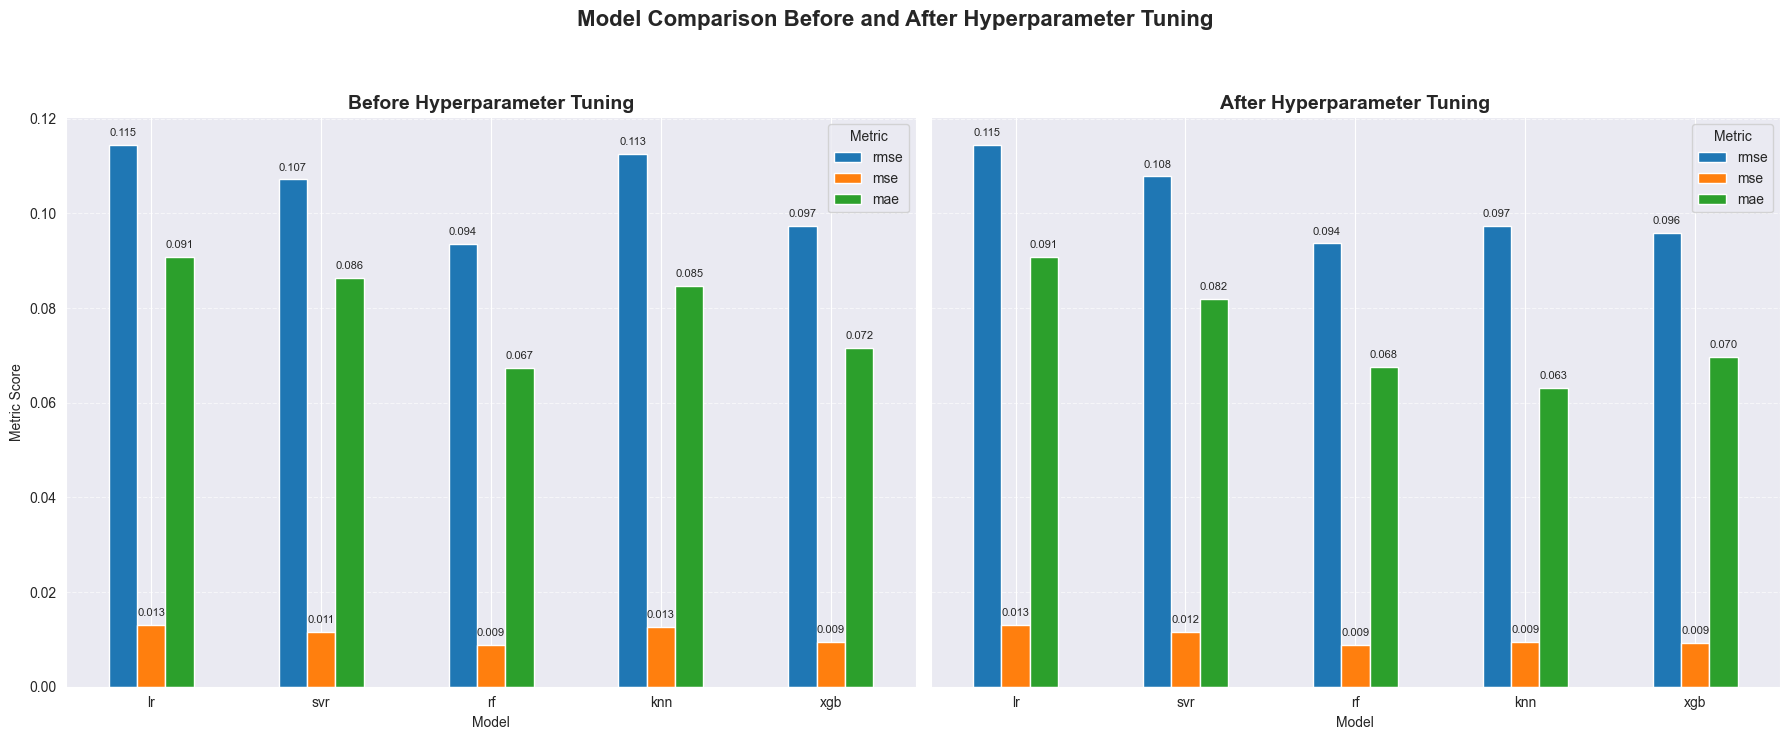

In [89]:
plot_compare_metrics_before_after(
    results_before=results,
    results_after=results_final
)